In [1]:
import numpy as np
import time 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Precision,Recall,Accuracy
import warnings
warnings.filterwarnings('ignore')
import glob
import os
from PIL import Image

In [2]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [3]:
dirpath = 'C:\\Users\\Andrew\\dataset\\kkanji\\kkanji2'
res = {}
classes = glob.glob(os.path.join(dirpath, '*'))
for c in classes:
    files = glob.glob(os.path.join(c, '*'))
    res[c] = len(files)
filtered_paths = [x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)[:50]]
filtered_classes = [os.path.basename(x) for x in filtered_paths]
print(filtered_classes)

['U+4E00', 'U+4E91', 'U+4E8B', 'U+4EBA', 'U+53C8', 'U+5165', 'U+7269', 'U+51FA', 'U+898B', 'U+5927', 'U+5B50', 'U+6B64', 'U+5176', 'U+4E5F', 'U+65E5', 'U+5C0F', 'U+65B9', 'U+4E0A', 'U+662F', 'U+4E09', 'U+4E2D', 'U+4F55', 'U+5019', 'U+5973', 'U+56FD', 'U+4E8C', 'U+6642', 'U+4ECA', 'U+5FA1', 'U+6709', 'U+6240', 'U+5FC3', 'U+524D', 'U+5408', 'U+6C34', 'U+8EAB', 'U+4E94', 'U+5C71', 'U+5341', 'U+540C', 'U+6C41', 'U+7D66', 'U+624B', 'U+7ACB', 'U+8695', 'U+69D8', 'U+4E4B', 'U+4E0B', 'U+5409', 'U+4E16']


In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_it = datagen.flow_from_directory(dirpath, class_mode='categorical', classes=filtered_classes,
                                       batch_size=32, target_size=(64, 64), color_mode='grayscale', subset='training')

val_it = datagen.flow_from_directory(dirpath, class_mode='categorical', classes=filtered_classes,
                                     batch_size=32, target_size=(64, 64), color_mode="grayscale", subset='validation')

Found 32707 images belonging to 50 classes.
Found 8150 images belonging to 50 classes.


Text(0.5, 0, 'U+4C61')

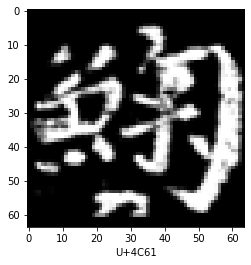

In [5]:
im = Image.open('C:\\Users\\Andrew\\dataset\\kkanji\\kkanji2\\U+4C61\\e6eeb23552e1a21c.png')
plt.imshow(im,cmap='gray')
plt.xlabel('U+4C61')

# Basic Model

In [6]:
NAME='BasicModel {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
   1/1023 [..............................] - ETA: 1s - loss: 3.9431 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00WARNING:tensorflow:From C:\Users\Andrew\anaconda3\envs\NAVI\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1023/1023 [==============================] - 158s 154ms/step - loss: 0.4324 - accuracy: 0.8901 - f1_score: 0.9021 - val_loss: 0.1513 - val_accuracy: 0.9610 - val_f1_score: 0.9627
Epoch 2/5
1023/1023 [==============================] - 152s 149ms/step - loss: 0.1062 - accuracy: 0.9708 - f1_score: 0.9723 - val_loss: 0.1332 - val_accuracy: 0.9667 - val_f1_score: 0.9697
Epoch 3/5
1023/1023 [==============================] - 152s 149ms/step - loss: 0.0543 - accuracy: 0.9839 - f1_score: 0.9844 - val_loss: 0.1238 - val_accuracy: 0.9702 - val_f1_score: 0.9716
Epoch 4/5
1023/1023 [======

# Change Filters' Dimensions

In [8]:
#Convolutions have higher kernel_size (4,4)
NAME='HighFilters {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 170s 166ms/step - loss: 0.4009 - accuracy: 0.8970 - f1_score: 0.9068 - val_loss: 0.1780 - val_accuracy: 0.9537 - val_f1_score: 0.9543
Epoch 2/5
1023/1023 [==============================] - 168s 165ms/step - loss: 0.0928 - accuracy: 0.9744 - f1_score: 0.9752 - val_loss: 0.1706 - val_accuracy: 0.9526 - val_f1_score: 0.9560
Epoch 3/5
1023/1023 [==============================] - 168s 164ms/step - loss: 0.0464 - accuracy: 0.9864 - f1_score: 0.9869 - val_loss: 0.1389 - val_accuracy: 0.9607 - val_f1_score: 0.9622
Epoch 4/5
1023/1023 [==============================] - 169s 165ms/step - loss: 0.0328 - accuracy: 0.9906 - f1_score: 0.9908 - val_loss: 0.1361 - val_accuracy: 0.9677 - val_f1_score: 0.9686
Epoch 5/5
1023/1023 [==============================] - 166s 162ms/step - loss: 0.0256 - accuracy: 0.9913 - f1_score: 0.9916 - val_loss: 0.1296 - val_accuracy: 0.9712 - val_f1_score: 0.9719
Time:  843.3192481994629


In [9]:
# Convolutions have lower kernel_size (2,2)
NAME='LowerFiltersDim {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 156s 153ms/step - loss: 0.4051 - accuracy: 0.8964 - f1_score: 0.9064 - val_loss: 0.1794 - val_accuracy: 0.9518 - val_f1_score: 0.9552
Epoch 2/5
1023/1023 [==============================] - 135s 132ms/step - loss: 0.0922 - accuracy: 0.9756 - f1_score: 0.9765 - val_loss: 0.1535 - val_accuracy: 0.9620 - val_f1_score: 0.9634
Epoch 3/5
1023/1023 [==============================] - 138s 135ms/step - loss: 0.0415 - accuracy: 0.9886 - f1_score: 0.9888 - val_loss: 0.1414 - val_accuracy: 0.9644 - val_f1_score: 0.9660
Epoch 4/5
1023/1023 [==============================] - 142s 139ms/step - loss: 0.0321 - accuracy: 0.9904 - f1_score: 0.9907 - val_loss: 0.1642 - val_accuracy: 0.9658 - val_f1_score: 0.9677
Epoch 5/5
1023/1023 [==============================] - 135s 132ms/step - loss: 0.0238 - accuracy: 0.9930 - f1_score: 0.9932 - val_loss: 0.1626 - val_accuracy: 0.9660 - val_f1_score: 0.9682
Time:  708.223347902298


# Change Strides

In [10]:
#Strides are bigger (2,2)
NAME='StridesBigger {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(2,2),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(2,2),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(2,2),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 35s 35ms/step - loss: 0.9433 - accuracy: 0.7479 - f1_score: 0.7561 - val_loss: 0.4304 - val_accuracy: 0.8775 - val_f1_score: 0.8821
Epoch 2/5
1023/1023 [==============================] - 34s 34ms/step - loss: 0.2974 - accuracy: 0.9160 - f1_score: 0.9187 - val_loss: 0.2771 - val_accuracy: 0.9223 - val_f1_score: 0.9241
Epoch 3/5
1023/1023 [==============================] - 40s 39ms/step - loss: 0.1734 - accuracy: 0.9511 - f1_score: 0.9526 - val_loss: 0.2207 - val_accuracy: 0.9384 - val_f1_score: 0.9388
Epoch 4/5
1023/1023 [==============================] - 35s 34ms/step - loss: 0.1145 - accuracy: 0.9672 - f1_score: 0.9677 - val_loss: 0.2112 - val_accuracy: 0.9396 - val_f1_score: 0.9432
Epoch 5/5
1023/1023 [==============================] - 35s 34ms/step - loss: 0.0825 - accuracy: 0.9743 - f1_score: 0.9747 - val_loss: 0.2257 - val_accuracy: 0.9405 - val_f1_score: 0.9424
Time:  182.02708959579468


# Change Padding 

In [11]:
#Padding=valid
NAME='PaddingValid {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',padding='valid',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu',padding='valid'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu',padding='valid'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 143s 140ms/step - loss: 0.4114 - accuracy: 0.8957 - f1_score: 0.9075 - val_loss: 0.1866 - val_accuracy: 0.9482 - val_f1_score: 0.9513
Epoch 2/5
1023/1023 [==============================] - 139s 136ms/step - loss: 0.0927 - accuracy: 0.9758 - f1_score: 0.9766 - val_loss: 0.1492 - val_accuracy: 0.9616 - val_f1_score: 0.9636
Epoch 3/5
1023/1023 [==============================] - 155s 152ms/step - loss: 0.0442 - accuracy: 0.9870 - f1_score: 0.9873 - val_loss: 0.1256 - val_accuracy: 0.9693 - val_f1_score: 0.9712
Epoch 4/5
1023/1023 [==============================] - 156s 152ms/step - loss: 0.0301 - accuracy: 0.9912 - f1_score: 0.9914 - val_loss: 0.1614 - val_accuracy: 0.9642 - val_f1_score: 0.9657
Epoch 5/5
1023/1023 [==============================] - 153s 150ms/step - loss: 0.0225 - accuracy: 0.9934 - f1_score: 0.9936 - val_loss: 0.1987 - val_accuracy: 0.9596 - val_f1_score: 0.9604
Time:  749.1669480800629


# Batch Normalization

In [12]:
#AddBatchNormalization
NAME='BatchNorm {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 192s 188ms/step - loss: 0.4113 - accuracy: 0.9098 - f1_score: 0.9155 - val_loss: 0.2644 - val_accuracy: 0.9411 - val_f1_score: 0.9428
Epoch 2/5
1023/1023 [==============================] - 188s 183ms/step - loss: 0.0988 - accuracy: 0.9760 - f1_score: 0.9765 - val_loss: 0.2223 - val_accuracy: 0.9558 - val_f1_score: 0.9569
Epoch 3/5
1023/1023 [==============================] - 196s 192ms/step - loss: 0.0899 - accuracy: 0.9780 - f1_score: 0.9782 - val_loss: 0.2659 - val_accuracy: 0.9493 - val_f1_score: 0.9504
Epoch 4/5
1023/1023 [==============================] - 172s 168ms/step - loss: 0.0728 - accuracy: 0.9827 - f1_score: 0.9831 - val_loss: 0.2129 - val_accuracy: 0.9626 - val_f1_score: 0.9638
Epoch 5/5
1023/1023 [==============================] - 172s 168ms/step - loss: 0.0397 - accuracy: 0.9895 - f1_score: 0.9897 - val_loss: 0.2190 - val_accuracy: 0.9609 - val_f1_score: 0.9619
Time:  922.4913692474365


# Average Pooling

In [13]:
#AveragePooling in the end
NAME='AveragePool {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 190s 185ms/step - loss: 0.4265 - accuracy: 0.9088 - f1_score: 0.9137 - val_loss: 0.2779 - val_accuracy: 0.9411 - val_f1_score: 0.9424
Epoch 2/5
1023/1023 [==============================] - 171s 167ms/step - loss: 0.1224 - accuracy: 0.9710 - f1_score: 0.9721 - val_loss: 0.2032 - val_accuracy: 0.9558 - val_f1_score: 0.9572
Epoch 3/5
1023/1023 [==============================] - 190s 186ms/step - loss: 0.0839 - accuracy: 0.9799 - f1_score: 0.9803 - val_loss: 0.2131 - val_accuracy: 0.9609 - val_f1_score: 0.9622
Epoch 4/5
1023/1023 [==============================] - 192s 188ms/step - loss: 0.0632 - accuracy: 0.9832 - f1_score: 0.9836 - val_loss: 0.2906 - val_accuracy: 0.9443 - val_f1_score: 0.9452
Epoch 5/5
1023/1023 [==============================] - 172s 168ms/step - loss: 0.0709 - accuracy: 0.9837 - f1_score: 0.9840 - val_loss: 0.2504 - val_accuracy: 0.9555 - val_f1_score: 0.9566
Time:  918.381822347641


# DropOut 20%

In [14]:
#DropOut 20%
NAME='DropOut20 {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 266s 260ms/step - loss: 0.5103 - accuracy: 0.8847 - f1_score: 0.8935 - val_loss: 0.4559 - val_accuracy: 0.8855 - val_f1_score: 0.8882
Epoch 2/5
1023/1023 [==============================] - 262s 256ms/step - loss: 0.1841 - accuracy: 0.9557 - f1_score: 0.9567 - val_loss: 0.5812 - val_accuracy: 0.8680 - val_f1_score: 0.8691
Epoch 3/5
1023/1023 [==============================] - 260s 255ms/step - loss: 0.1337 - accuracy: 0.9684 - f1_score: 0.9693 - val_loss: 0.2836 - val_accuracy: 0.9252 - val_f1_score: 0.9297
Epoch 4/5
1023/1023 [==============================] - 261s 255ms/step - loss: 0.1081 - accuracy: 0.9729 - f1_score: 0.9735 - val_loss: 0.2322 - val_accuracy: 0.9401 - val_f1_score: 0.9428
Epoch 5/5
1023/1023 [==============================] - 270s 264ms/step - loss: 0.0771 - accuracy: 0.9807 - f1_score: 0.9811 - val_loss: 0.2166 - val_accuracy: 0.9475 - val_f1_score: 0.9491
Time:  1323.5701713562012


# DropOut 40%

In [15]:
#DropOut 40%
NAME='DropOut40 {}'.format(int(time.time()))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME))

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(2,2),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,kernel_size=(2,2),strides=(1,1),activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32,callbacks=[tensorboard])
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 270s 264ms/step - loss: 0.6326 - accuracy: 0.8569 - f1_score: 0.8663 - val_loss: 2.1338 - val_accuracy: 0.5182 - val_f1_score: 0.5167
Epoch 2/5
1023/1023 [==============================] - 267s 261ms/step - loss: 0.2750 - accuracy: 0.9361 - f1_score: 0.9389 - val_loss: 0.7451 - val_accuracy: 0.8085 - val_f1_score: 0.8136
Epoch 3/5
1023/1023 [==============================] - 269s 263ms/step - loss: 0.2055 - accuracy: 0.9496 - f1_score: 0.9511 - val_loss: 1.5448 - val_accuracy: 0.6448 - val_f1_score: 0.6449
Epoch 4/5
1023/1023 [==============================] - 268s 262ms/step - loss: 0.1503 - accuracy: 0.9619 - f1_score: 0.9629 - val_loss: 0.7541 - val_accuracy: 0.8000 - val_f1_score: 0.7904
Epoch 5/5
1023/1023 [==============================] - 265s 259ms/step - loss: 0.1394 - accuracy: 0.9642 - f1_score: 0.9654 - val_loss: 0.7866 - val_accuracy: 0.7848 - val_f1_score: 0.7864
Time:  1346.116518497467


# Best Model 

In [17]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(50,activation='softmax')
])
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy',F1_Score()])
time1 = time.time()
history = model.fit(train_it, validation_data=val_it,epochs=5,
                    batch_size=32)
time2 = time.time()
print("Time: ",time2-time1)

Epoch 1/5
1023/1023 [==============================] - 158s 155ms/step - loss: 0.3804 - accuracy: 0.9056 - f1_score: 0.9157 - val_loss: 0.1400 - val_accuracy: 0.9647 - val_f1_score: 0.9665
Epoch 2/5
1023/1023 [==============================] - 165s 161ms/step - loss: 0.0890 - accuracy: 0.9767 - f1_score: 0.9775 - val_loss: 0.1246 - val_accuracy: 0.9667 - val_f1_score: 0.9678
Epoch 3/5
1023/1023 [==============================] - 164s 161ms/step - loss: 0.0458 - accuracy: 0.9872 - f1_score: 0.9873 - val_loss: 0.1164 - val_accuracy: 0.9724 - val_f1_score: 0.9725
Epoch 4/5
1023/1023 [==============================] - 167s 163ms/step - loss: 0.0320 - accuracy: 0.9909 - f1_score: 0.9910 - val_loss: 0.1298 - val_accuracy: 0.9729 - val_f1_score: 0.9740
Epoch 5/5
1023/1023 [==============================] - 187s 183ms/step - loss: 0.0241 - accuracy: 0.9926 - f1_score: 0.9929 - val_loss: 0.1146 - val_accuracy: 0.9729 - val_f1_score: 0.9737
Time:  844.5163061618805


'U+4E91'

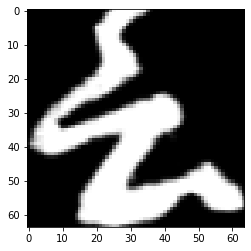

In [18]:
#U+4E91
path = 'C:\\Users\\Andrew\\dataset\\kkanji\\kkanji2\\U+4E91\\000ea841c679ff7d.png'

image = tf.keras.preprocessing.image.load_img(path, target_size=(64, 64), color_mode='grayscale')
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr /= 255.

plt.imshow(image,cmap='gray')
pred = filtered_classes[np.argmax(model.predict(np.array([image_arr])))]
pred